# Import Packages and Data
**File name:** profile.json

Rewards program users (17000 users x 5 fields). Details the different offers sent during the test period, including offer type (buy-one-get-one, discount, informational), reward amount, required spending threshold, duration, and delivery channels.
* age (int) - age of the customer (missing value is encoded as 118)
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

profile = pd.read_json(r'data\01_raw\profile.json', lines=True)
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


# Clean up the dataframe

In [2]:
# Rename the 'id' column to 'customer_id'
profile = profile.rename(columns={'id': 'customer_id'})

#make customer id the first column
cols = ['customer_id'] + [col for col in profile if col != 'customer_id']
profile = profile[cols]

#Convert 'became_member_on' to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# Calculate membership duration in days from the max date in the dataset
profile['days_as_member'] = (profile['became_member_on'].max()- profile['became_member_on']).dt.days

# Replace None with NaN
profile['gender'] = profile['gender'].fillna(np.nan)

# Replace 118 with NaN
profile['age'] = profile['age'].replace(118, np.nan)

# Save the cleaned data 
profile.to_csv(r'data\02_stg\stg_profile.csv', index=False)
profile.to_pickle(r'data\02_stg\stg_profile.pkl')

profile.head()

,customer_id,gender,age,became_member_on,income,days_as_member
0,68be06ca386d4c31939f3a4f0e3dd783,NaN,NaN,2017-02-12,NaN,529
1,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,376
2,38fe809add3b4fcf9315a9694bb96ff5,NaN,NaN,2018-07-12,NaN,14
3,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,443
4,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,2017-08-04,NaN,356


# Summary

## Data Density

In [3]:
# Percentage of missing values in each column
nan_percent = round(profile.isna().mean() * 100, 2)
print(nan_percent)

customer_id          0.00
gender              12.79
age                 12.79
became_member_on     0.00
income              12.79
days_as_member       0.00
dtype: float64


## Data Distribution

In [4]:
#Overall Profile Statistics
profile_statistics = profile[['days_as_member', 'age', 'income']].describe().astype(int).T
profile_statistics = profile_statistics.drop('count', axis=1)
profile_statistics

,mean,std,min,25%,50%,75%,max
days_as_member,517,411,0,208,358,791,1823
age,54,17,18,42,55,66,101
income,65404,21598,30000,49000,64000,80000,120000


In [5]:
# Replace NaN values with 'Unknown'
profile['gender'] = profile['gender'].fillna('Unknown')

# Calculate value counts
gender_counts = profile['gender'].value_counts(dropna=False).to_frame().reset_index()
gender_counts.columns = ['gender', 'num_cust']

# Calculate percentages
gender_percentages = profile['gender'].value_counts(normalize=True, dropna=False).mul(100).round(2).to_frame().reset_index()
gender_percentages.columns = ['gender', 'percentage_cust']

# Merge the two DataFrames
gender_stats = pd.merge(gender_counts, gender_percentages, on='gender')

# Here we can see that 13.86% more men than women are signed up for the rewards program
gender_stats

,gender,num_cust,percentage_cust
0,M,8484,49.91
1,F,6129,36.05
2,Unknown,2175,12.79
3,O,212,1.25


In [6]:
def get_mean_profile(gender):
    profile_data = profile[profile['gender'] == gender]
    mean_profile = profile_data[['days_as_member', 'age', 'income']].mean().round().to_frame().T
    mean_profile.index = [gender]
    return mean_profile

# Apply the function to each gender
gender_means = pd.concat([get_mean_profile(gender) for gender in ['M', 'F', 'O', 'Unknown']])

# Reset the index to make 'gender' a column
gender_means.reset_index(inplace=True)

# Rename the columns
gender_means.rename(columns={
    'index':'gender',
    'days_as_member': 'avg_days_as_member',
    'age': 'avg_age',
    'income': 'avg_income'
}, inplace=True)

gender_means

,gender,avg_days_as_member,avg_age,avg_income
0,M,530.0,52.0,61195.0
1,F,513.0,58.0,71306.0
2,O,487.0,54.0,63288.0
3,Unknown,483.0,NaN,NaN


In [7]:
# Merge gender_stats and gender_means
gender_stats = pd.merge(gender_stats, gender_means, on='gender')

#Export the data
gender_stats.to_csv(r'data\04_fct\fct_gender_stats.csv', index=False)

gender_stats

,gender,num_cust,percentage_cust,avg_days_as_member,avg_age,avg_income
0,M,8484,49.91,530.0,52.0,61195.0
1,F,6129,36.05,513.0,58.0,71306.0
2,Unknown,2175,12.79,483.0,NaN,NaN
3,O,212,1.25,487.0,54.0,63288.0


# Segement Customers

In [8]:
#Create age categories
bins = [18, 25, 35, 45, 55, 65, 75, 102]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
profile['age_group'] = pd.cut(profile['age'], bins=bins, labels=labels, right=False)
profile = profile.drop('age', axis=1)

#Create income categories
bins = [30000, 50000, 75000, 100000, 120001]
labels = ['<50K', '50K-74K', '75K-99K', '100K+']
profile['income_group'] = pd.cut(profile['income'], bins=bins, labels=labels, right=False)
profile = profile.drop('income', axis=1)

# Convert 'became_member_on' to datetime if it's not already
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'])

# Extract the quarter and year from the 'became_member_on' date
profile['membership_quarter'] = profile['became_member_on'].dt.quarter
profile['membership_year'] = profile['became_member_on'].dt.year

# Combine the quarter and year into a single column
profile['member_since'] = profile['membership_year'].astype(str) + ' Q' + profile['membership_quarter'].astype(str)

# Drop the 'days_as_member', 'became_member_on', 'membership_quarter', and 'membership_year' columns
profile = profile.drop(['days_as_member', 'became_member_on', 'membership_quarter', 'membership_year'], axis=1)

# Export the data
profile.to_csv(r'data\03_int\int_profile_segmentation.csv', index=False)
profile.to_pickle(r'data\03_int\int_profile_segmentation.pkl')

profile.head()

,customer_id,gender,age_group,income_group,member_since
0,68be06ca386d4c31939f3a4f0e3dd783,Unknown,NaN,NaN,2017 Q1
1,0610b486422d4921ae7d2bf64640c50b,F,55-64,100K+,2017 Q3
2,38fe809add3b4fcf9315a9694bb96ff5,Unknown,NaN,NaN,2018 Q3
3,78afa995795e4d85b5d9ceeca43f5fef,F,75+,100K+,2017 Q2
4,a03223e636434f42ac4c3df47e8bac43,Unknown,NaN,NaN,2017 Q3


In [9]:
# Group by the categorical variables and count the number of customer_ids
cat_vars = ['gender', 'age_group', 'income_group', 'member_since']
max_seg = profile.groupby(cat_vars, observed=True)['customer_id'].count()

# Convert the max_seg data to a DataFrame and reset the index
df_max_seg = max_seg.reset_index()

# Rename the customer_id column to count
df_max_seg.rename(columns={'customer_id': 'cust_count'}, inplace=True)
df_max_seg = df_max_seg.sort_values('cust_count', ascending=False)

# Save the data to a .csv file
df_max_seg.to_csv(r'data\04_fct\fct_profiles_by_income_quarter.csv', index=False)

df_max_seg.head()

,gender,age_group,income_group,member_since,cust_count
629,M,45-54,50K-74K,2017 Q4,128
705,M,55-64,50K-74K,2017 Q3,110
707,M,55-64,50K-74K,2018 Q1,98
782,M,65-74,50K-74K,2017 Q4,98
631,M,45-54,50K-74K,2018 Q2,98


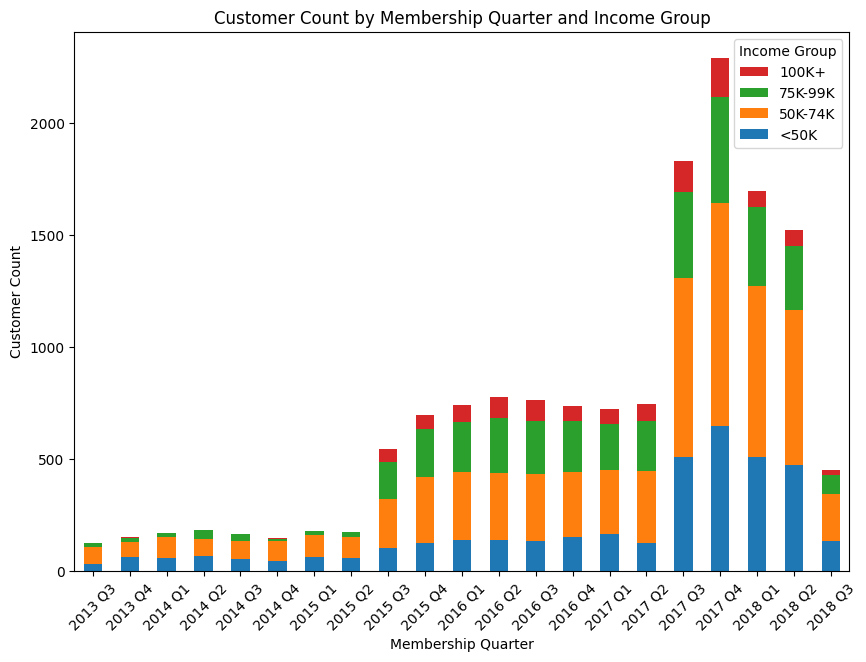

In [10]:
# Aggregate the data
df_agg = df_max_seg.groupby(['member_since', 'income_group'], observed=True)['cust_count'].sum().reset_index()

# Pivot the DataFrame so that each income group is a separate column
df_pivot = df_agg.pivot(index='member_since', columns='income_group', values='cust_count')

# Plot a stacked bar chart
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(10,7))

# Angle the x-axis labels
plt.xticks(rotation=45)

# Sort the legend in descending order
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Income Group')

# Add a title and labels for the x and y axes
plt.title('Customer Count by Membership Quarter and Income Group')
plt.xlabel('Membership Quarter')
plt.ylabel('Customer Count')

# Show the plot
plt.show()